# Announcements
- Problem 3 posted on D2L, due on 9/21/2020. Submission of notebooks encouraged(one per problem set, each problem labeled)
- Solutions to Monday's breakout room exercise posted on D2L in ``Lecture 9``
- Markdown cheat sheet posted on D2L in ``Course Notes``

<style>
@import url(https://www.numfys.net/static/css/nbstyle.css);
</style>
<a href="https://www.numfys.net"><img class="logo" /></a>

# Ordinary Differential Equations - higher order methods

<section class="post-meta">
Based on notes and notebooks by Niels Henrik Aase, Thorvald Ballestad, Vasilis Paschalidis and Jon Andreas Støvneng
</section>


## Recap


Physics equations of motion require the solution of ordinary
differential equations (ODE). While the vast majority of equations in
Physics are partial differential equations, ordinary differential
equations pop-up in scenarios where a high degree of symmetry and/or
stationarity (time-independence) is imposed (e.g., stationary and
spherically symmetric). For example, in Newtonian gravity the
equation for the gravitational potential is

$$
\nabla^2 \Phi = 4\pi G \rho,
$$
but in spherical symmetry this becomes an ODE

$$
\frac{1}{r^2}\frac{d}{dr}\left(r^2\frac{d}{dr} \Phi\right) = 4\pi G \rho.
$$

The Newtonian equation of motion is also a second-order ODE in time (acceleration=force/mass),
$$
\frac{d^2 x}{dt^2} = F/m
$$
For a very complex density distribution or complicated
(time-dependent) forces, these last equations are not easily solved
analytically. So, in such cases we need to solve the ODEs numerically.
There are multiple ways one can numerically solve ODEs, and we will
review here some of these methods including the Euler, and Runge-Kutta
methods. 

### Initial value problems
An initial value problem (IVP) for ODEs is described by the following
equations
$$
\frac{d}{dt} y(t)=g(y(t), t), a \leq t \leq b,\;\; \mbox{ Initial conditions: } y(a)=\alpha
$$
for a single ODE, and
$$
\frac{d}{dt} \vec y=\vec G(y(t), t), a \leq t \leq b,\;\; \mbox{ Initial conditions: } \vec y(a)=\vec\alpha,
$$
where
$$
\vec y =(y_1, y_2, \ldots y_n), \ \vec G =(g_1(\vec y(t), t), g_2(\vec y(t), t) \ldots g_n(\vec y(t), t)).
$$
for a system of coupled ODEs.

Before we decide to code any differential equation in a computer it is
always important to be able to answer the following questions:
- (1) Does the ODE have a solution? 
- (2) Is the ODE solution unique for a given initial conditions? 
- (3) Does the solution depend continuously on the initial conditions? 

All three questions point to the concept of
well-posedness of the IVP. *If the answer is NO to any of these 3
questions, the IVP is not well-posed, and it is redundant to try to
solve the ODE as an IVP, as the numerical algorithm will fail.* In this
first section we will introduce the mathematical background for
answering the above questions.


#### Definition: Well-posedness of the IVP
The IVP
$$\frac{dy}{dt}=g(y,t), a \leq t \leq b, \mbox{ Initial conditions: } y(a)=\alpha
$$
is __well-posed__ if
- A unique solution $y(t)$ exists
- There exist constants $\epsilon_0>0$, $k>0$ such that $\forall
  \epsilon >0$ with $\epsilon_0 > \epsilon >0$, whenever $\delta(t)$
  is continuous with $|\delta(t)| < \epsilon$ $\forall t \in [a,b]$,
  and $\delta_0 < \epsilon$, the IVP
$$    \frac{dz}{dt}=g(z,t)+\delta(t), a \leq t \leq b, \mbox{ Initial conditions: } z(a)=\alpha+\delta_0 \label{pert}\tag{1}
$$  has a unique solution $z(t)$ that satisfies
$$    |z(t)-y(t)| < k \epsilon_0, \ \forall t \in [a,b].\label{stab}\tag{2}$$  
  

#### Theorem 
Assume $D = \{(y,t)\ |-\infty < y < \infty,\ a \leq t \leq b\}$, where $g(y,t)$ is continuous and is
Lipschitz continuous in $y$ on $D$, then the IVP
$$\frac{dy}{dt}=g(y,t), a \leq t \leq b, \mbox{ Initial conditions: } y(a)=\alpha$$
is well-posed.

Well-posedness is a fundamental property of initial value problems for
ordinary and partial differential equations. If a differential
equation does not admit a well-posed initial value problem, then we
cannot integrate it numerically.If a small perturbation either in
initial conditions or in the right-hand-side of Eq.\ref{pert} leads
the difference between the solution $z(t)$ and $y(t)$ to grow without
bound, then this problem is ill-posed and cannot be integrated in a
computer. The reason is that computers will always have finite error,
i.e., will always apply small perturbations in the form of either
truncation or round-off error. *More specifically well-posedness
implies continuous dependence on the initial data.*


## Algorithms for initial value problem ODEs


Assume we have a first-order differential equation which can be expressed in the form

$$ \frac{dy}{dt} = g(y,t) $$

We will solve this on constant-interval mesh of the independent variable $t$ defined by

$$ t_n = t_0 + n h $$

### Forward-Euler method

In Lecture 10 we derived Euler's method, which simply solves the first-order forward difference approximation to $dy/dt$

$$ \frac{y_{i+1}-y_i}{h} = g(y_i,t_i)$$

as

$$ y_{i+1} = y_i + h g(y_i,t_i) \label{Euler_fwd}\tag{3}$$

In [3]:
# Importing the necessary libraries
import numpy as np # NumPy is used to generate arrays and to perform some mathematical operations
import matplotlib.pyplot as plt # Used for plotting results



In [4]:
def forwardEuler_step(t, y, h, g, *P):
    """
    Implements a single step of the forward-Euler finite-difference scheme
    Parameters:
            t: time t
            y: Numerical approximation of y at time t
            h: Step size
            g: RHS of our ODE (RHS = Right hand side). Can be any function with signature g(t,y,*P).
            *P: tuple of parameters, arguments to g
        Returns:
            next_y: Numerical approximation of y at time t+h
    """
    next_y = y + h*g(t, y, *P)
    return next_y



We now need some sort of framework which will take this function and do the integration for us. Let's rewrite `full_Euler` from Lecture 10 to be more general:

In [5]:
def odeSolve(t0, y0, tmax, h, g, method, *P):
    """ A full numerical aproximation of an ODE in a set time interval. Performs consecutive steps of `method`
    with step size h from start time until the end time. Also takes into account the initial values of the ODE
    
    Parameters:
            t0: start time
            y0 : Initial condition for y at t = t0
            tmax: The end of the interval where the `method` is integrated, t_N
            h: Step size
            g: RHS of our ODE (RHS = Right hand side). Can be any function with signature g(t,y,*P).
            *P: tuple of parameters, arguments to g
        Returns:
            t_list: Evenly spaced discrete list of time with spacing h. 
                    Starting time = start_t, and end time = end_t 
            y_list: Numerical approximation of y at times t_list
    """    
    # make the t-mesh; guarantees we stop precisely at tmax
    t_list = np.arange(t0,tmax+h,h)
    # allocate space for the solution
    y_list = np.zeros_like(t_list)
    # set the initial condition
    y_list[0] = y0
    
    # find out the size of the t-mesh, and then integrate forward one meshpoint per iteration of the loop
    n, = t_list.shape
    for i in range(0,n-1):
        y_list[i+1] = method(t_list[i], y_list[i], h, g, *P)
        
    # return the solution
    return t_list,y_list

Armed with this machinery, let's set up another simple problem and try it out.

Last time, we looked at exponential growth, let's solve exponential decay this time:

$$ \frac{dy}{dt} = - c y, \quad y[0] = 1 $$

First, we provide a function to implement the RHS:

In [6]:
def expRHS(t, y, c):
    """
    Implements the RHS (y'(x)) of the DE
    """
    return -c*y

Now we set up the problem to compute and plot the result, along with a plot of the magnitude of the fractional error

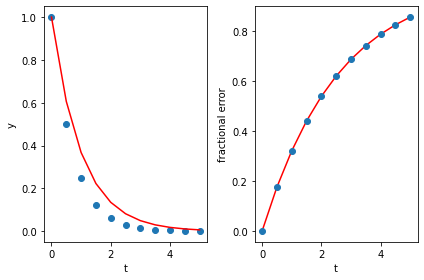

In [7]:
# set up problem
c = 1.0
h = 0.5
t0 = 0.0
y0 = 1.0
tmax = 5.0

# call the solver
t, y = odeSolve(t0, y0, tmax, h, expRHS, forwardEuler_step, c)

# plot the result
fig,ax = plt.subplots(1,2)
ax[0].plot(t,y,'o')
ans = np.exp(-c*t)
ax[0].plot(t,ans,'r')
ax[0].set_xlabel('t')
ax[0].set_ylabel('y')

# along with the errors
err = np.abs((ans-y)/ans)
ax[1].plot(t, err, 'r')
ax[1].plot(t, err, 'o')
ax[1].set_xlabel('t')
ax[1].set_ylabel('fractional error')


# this gives better spacing between axes
plt.tight_layout()
plt.show()

In developing the forward Euler method, we expanded the solution about time $t$,
the beginning of the interval; we can just as easily expand backwards about
$t+h$
\begin{equation}
  f(t) = f(t+h) - h f'(t+h) + \frac{h^2}{2} f''(t+h) + \dots
\end{equation}
Proceeding as before, keeping terms to $\mathcal{O}(h)$, we have
\begin{equation}
  \frac{f(t+h)-f(t)}{h} = f'(t+h)
\end{equation}
giving the update formula
\begin{equation}
  f_{i+1} = f_i + f'_{i+1}
\end{equation}
In this case, we may not be able to solve explicitly for $f_{i-1}$ since $f'$ is evaluated at $t+h$
on the RHS; this is known as an _implicit_ method. While we may not be able to solve for
$f_{n+1}$ analytically, we can always employ some of the numerical techniques for solving nonlinear
equations we have already seen.

The Euler method as implemented above corresponds to Riemann integration for integral - we use the value of the function at $t_i$ to predict its value at $t_{i+1}$. Similar to integration of functions, we can improve convergence by turning to higher order methods that include information on the function behavior within $[t_i,t_{i+1}]$.


![image](midpoint.png)

##### Explicit midpoint method
By averaging the forward- and backward-Euler scheme, it can be shown that
\begin{equation}
  f_{i+1} = f_i + \frac{h}{2} f'_{i+\frac{1}{2}} + \mathcal{O}(h^3)
\end{equation}
but now we need to evaluate the derivative at the half time step! 

With some Taylor expansion tricks, it can be shown that the explict midpoint method can be written as

\begin{align}
\begin{split}
y_{i+\frac{1}{2}} &= y_i + \frac{h}{2} RHS(t_i, y_i) \\
y_{i+1} &= y_i + h RHS(t_i + \frac{1}{2}h, y_{i+\frac{1}{2}})\,,
\end{split}
\end{align}
which is second-order in $h$.

### Runge-Kutta Schemes

The idea of the Runge-Kutta schemes is to take advantage of derivative information at the times between $t_i$ and $t_{i+1}$ to increase the order of accuracy.

For example, in the midpoint method, the derivative at the initial time is used to approximate the derivative at the midpoint of the interval, $f(y_i+\frac{1}{2}hf(y_i,t_i), t_i+\frac{1}{2}h)$. The derivative at the midpoint is then used to advance the solution to the next step. The method can be written in two stages $k_i$,

$$ \begin{aligned} \begin{array}{l} k_1 = h f(y_i,t_i)\\ k_2 = h f(y_i+\frac{1}{2}k_1, t_n+\frac{1}{2}h)\\ y_{i+1} = y_i + k_2 \end{array} \end{aligned}\label{RK2}\tag{4} $$

The midpoint method is known as a __2nd-order Runge-Kutta__ formula.


In general, an explicit 2-stage Runge-Kutta method can be written as,
$$ \begin{array}{l} k_1 = h f(y_n,t_n)\\ k_2 = h f(y_n+b_{21}k_1, t_n+a_2h)\ \\ y_{n+1} = y_n + c_1k_1 +c_2k_2 \label{explicitrk2}\tag{5}\end{array} $$

The scheme is said to be *explicit* since a given stage does not depend *implicitly* on itself, as in the backward Euler method , or on a later stage.

Other explicit second-order schemes can be derived by comparing Eq.(\ref{explicitrk2}) to other second-order expansions and matching terms to determine the coefficients $a_2$, $b_{21}$, $c_1$ and $c_2$.

### Explicit Fourth-Order Runge-Kutta Method

Explicit Runge-Kutta methods are popular as each stage can be calculated with one function evaluation. In contrast, implicit Runge-Kutta methods usually involves solving a non-linear system of equations in order to evaluate the stages. As a result, explicit schemes are much less expensive to implement than implicit schemes.

The higher-order Runge-Kutta methods can be derived by in manner similar to the midpoint formula. An s-stage method is compared to a Taylor method and the terms are matched up to the desired order.

Methods of order $M > 4$ require $M+1$ or $M+2$ function evaluations or stages, in the case of explicit Runge-Kutta methods. As a result, fourth-order Runge-Kutta methods have achieved great popularity over the years as they require only four function evaluations per step. In particular, there is the classic fourth-order Runge-Kutta formula:
$$ \begin{array}{l} k_1 = h f(y_n,t_n)\\ k_2 = h f(y_n+\frac{k_1}{2}, t_n+\frac{h}{2})\\ k_3 = h f(y_n+\frac{k_2}{2}, t_n+\frac{h}{2})\\ k_4 = h f(y_n+k_3, t_n+h)\\ y_{n+1} = y_n + \frac{k_1}{6}+ \frac{k_2}{3}+ \frac{k_3}{3} + \frac{k_4}{6} \label{RK4}\tag{6}\end{array} $$

### Break-out Practice 
<span style="color:blue"> Implement the 2-nd order Runge-Kutta step `RK2_step(t, y, h, g, *P)` using the Equations(\ref{RK2}).</span>
<span style="color:blue"> Implement the 4-th order Runge-Kutta step `RK4_step(t, y, h, g, *P)` using the Equations(\ref{RK4}).</span>

<span style="color:blue"> Rerun the example problem from above and compare the errors from RK2, RK4 and forward-Euler</span>


In [13]:
def RK2_step(t, y, h, g, *P):
    """
    Implements a single step of the second-order, explicit midpoint method
    """


In [18]:
def RK4_step(t, y, h, g, *P):
    """
    Implements a single step of a fourth-order, explicit Runge-Kutta scheme
    """


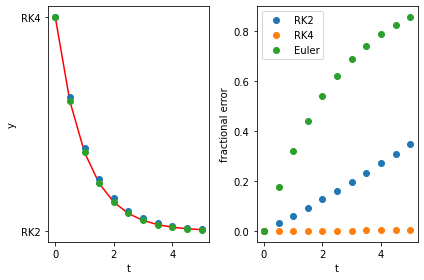

In [19]:
# set up problem
c = 1.0
h = 0.5
t0 = 0.0
y0 = 1.0
tmax = 5.0

# call the solver for RK2
t, y2 = odeSolve(t0, y0, tmax, h, expRHS, RK2_step, c)
# call the solver for RK4
t, y4 = odeSolve(t0, y0, tmax, h, expRHS, RK4_step, c)

# plot the result
fig,ax = plt.subplots(1,2)
ans = np.exp(-c*t)
ax[0].plot(t,ans,'r')
ax[0].set_xlabel('t')
ax[0].set_ylabel('y')

ax[0].plot(t,y2,'o','RK2')

ax[0].plot(t,y4,'o','RK4')

# along with the errors
err = np.abs((ans-y)/ans)
ax[1].plot(t, err, 'o')
ax[1].set_xlabel('t')
ax[1].set_ylabel('fractional error')
ax[1].legend()
# now also overplot the error we calculated for forward-Euler

# this gives better spacing between axes
plt.tight_layout()
plt.show()